In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc

# Load Data

In [2]:
df = pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz", sep='\t', compression='gzip', index_col=0, skiprows=2).drop("Description", 1)
df = df.divide(df.sum(0), 1)
gc.collect()
df.head()

,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,GTEX-1117F-3026-SM-5GZYU,GTEX-1117F-3226-SM-5N9CT,GTEX-111CU-0126-SM-5GZWZ,GTEX-111CU-0226-SM-5GZXC,GTEX-111CU-0326-SM-5GZXO,GTEX-111CU-0426-SM-5GZY1,GTEX-111CU-0526-SM-5EGHK,GTEX-111CU-0626-SM-5EGHL,GTEX-111CU-0726-SM-5GZYD,GTEX-111CU-0826-SM-5EGIJ,GTEX-111CU-0926-SM-5EGIK,GTEX-111CU-1026-SM-5EGIL,GTEX-111CU-1126-SM-5EGIM,GTEX-111CU-1226-SM-5EGIN,GTEX-111CU-1326-SM-5NQ8L,GTEX-111CU-1426-SM-5GZYP,GTEX-111CU-1526-SM-5N9FS,GTEX-111CU-1726-SM-5EGHM,GTEX-111CU-1826-SM-5GZYN,GTEX-111CU-2026-SM-5GZZC,GTEX-111CU-2226-SM-5N9G5,GTEX-111FC-0126-SM-5N9DL,GTEX-111FC-0226-SM-5N9B8,GTEX-111FC-0326-SM-5GZZ1,GTEX-111FC-0426-SM-5N9CV,GTEX-111FC-0526-SM-5GZZ8,GTEX-111FC-0626-SM-5N9CU,GTEX-111FC-0826-SM-5GZWO,GTEX-111FC-1026-SM-5GZX1,GTEX-111FC-1126-SM-5GZWU,...,GTEX-ZZ64-0526-SM-5GZXM,GTEX-ZZ64-0626-SM-5GZWR,GTEX-ZZ64-0726-SM-5GZX4,GTEX-ZZ64-0826-SM-5E449,GTEX-ZZ64-0926-SM-5E44L,GTEX-ZZ64-1026-SM-5GZXG,GTEX-ZZ64-1126-SM-5GZXY,GTEX-ZZ64-1226-SM-5E43R,GTEX-ZZ64-1326-SM-5E444,GTEX-ZZ64-1426-SM-5NQ8C,GTEX-ZZ64-1526-SM-5E43K,GTEX-ZZ64-1626-SM-5E43W,GTEX-ZZ64-1726-SM-5GZYB,GTEX-ZZPT-0226-SM-5E43X,GTEX-ZZPT-0626-SM-5GZXT,GTEX-ZZPT-0926-SM-5GICZ,GTEX-ZZPT-1326-SM-5E43H,GTEX-ZZPT-1426-SM-5N9C5,GTEX-ZZPT-2926-SM-5EQ5S,GTEX-ZZPT-3026-SM-5GZXH,GTEX-ZZPU-0126-SM-5E446,GTEX-ZZPU-0226-SM-5N9BV,GTEX-ZZPU-0326-SM-5N9BJ,GTEX-ZZPU-0426-SM-5GZYH,GTEX-ZZPU-0526-SM-5E44U,GTEX-ZZPU-0626-SM-5E43T,GTEX-ZZPU-0726-SM-5N9C8,GTEX-ZZPU-0826-SM-5GZX5,GTEX-ZZPU-0926-SM-5GZYT,GTEX-ZZPU-1026-SM-5E457,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.599652e-08,3.189750e-08,3.001433e-08,0.000000e+00,1.334191e-08,0.000000e+00,0.000000e+00,4.733478e-08,0.000000e+00,8.708530e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.621645e-08,0.000000e+00,1.537451e-07,0.000000,0.000000e+00,1.592622e-08,0.000000,0.000000e+00,1.584481e-08,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,3.474004e-08,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2.864857e-07,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.995845e-08,1.867332e-08,0.000000,4.994014e-08,2.258183e-08,1.617363e-08,1.072646e-07,1.437597e-08,0.000000e+00,1.739949e-08,3.185180e-08,2.788156e-08,3.562418e-08,0.000000e+00,0.000000e+00,1.635785e-08,0.000000e+00,2.776099e-08,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.524040e-08,1.707736e-08
ENSG00000227232.5,3.870016e-06,0.000002,3.267126e-06,4.852006e-06,0.000002,0.000003,0.000005,8.221861e-06,0.000006,6.308335e-06,5.414279e-06,4.766962e-06,6.060525e-07,9.004298e-07,9.133895e-07,1.307507e-06,6.048269e-07,7.409168e-07,5.364609e-07,9.256943e-07,7.547392e-07,5.497699e-07,2.747508e-06,9.620318e-07,0.000001,7.946061e-07,2.353460e-06,1.713159e-06,0.000001,6.023807e-07,2.388933e-06,0.000003,2.089922e-06,8.239299e-07,0.000001,3.308003e-06,1.737021e-06,2.009986e-06,0.000004,0.000003,...,4.481466e-06,0.000001,0.000002,0.000002,7.330998e-06,2.215747e-06,2.639761e-06,1.558344e-06,0.000002,0.000003,0.000001,2.216350e-06,0.000004,2.198349e-06,1.975886e-06,1.848659e-06,0.000002,4.128385e-06,2.167855e-06,1.407106e-06,1.716234e-06,1.164453e-06,7.577404e-07,6.959797e-07,1.449257e-06,1.003736e-06,1.514028e-06,3.367496e-06,7.102592e-07,1.423133e-06,1.018203e-06,1.332528e-06,2.857631e-06,0.000002,1.234281e-06,1.923041e-06,0.000001,1.321591e-06,5.181736e-07,1.1271

In [29]:
df_files = pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep="\t").set_index("SAMPID")
df_files.head()

,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,SMNABTCH,SMNABTCHT,SMNABTCHD,SMGEBTCH,SMGEBTCHD,SMGEBTCHT,SMAFRZE,SMGTC,SME2MPRT,SMCHMPRS,SMNTRART,SMNUMGPS,SMMAPRT,SMEXNCRT,SM550NRM,SMGNSDTC,SMUNMPRT,SM350NRM,SMRDLGTH,SMMNCPB,SME1MMRT,SMSFLGTH,SMESTLBS,SMMPPD,SMNTERRT,SMRRNANM,SMRDTTL,SMVQCFL,SMMNCV,SMTRSCPT,SMMPPDPR,SMCGLGTH,SMGAPPCT,SMUNPDRD,SMNTRNRT,SMMPUNRT,SMEXPEFF,SMMPPDUN,SME2MMRT,SME2ANTI,SMALTALG,SME2SNSE,SMMFLGTH,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
SAMPID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F-0003-SM-58Q7G,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,DNA isolation_Whole Blood_QIAGEN Puregene (Man...,05/02/2013,LCSET-4574,01/15/2014,Standard Exome Sequencing v3 (ICE),WES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-5DWSB,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,DNA isolation_Whole Blood_QIAGEN Puregene (Man...,05/02/2013,GTEx_OM25_Dec_01,01/28/2014,Illumina OMNI SNP Array,OMNI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-6WBT7,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,DNA isolation_Whole Blood_QIAGEN Puregene (Man...,05/02/2013,LCSET-6056,09/20/2014,PCR+ 30x Coverage WGS v2 (HiSeqX),WGS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0011-R10a-SM-AHZ7F,NaN,"B1, A1",NaN,NaN,Brain,Brain - Frontal Cortex (BA9),0009834,1193.0,NaN,NaN,NaN,NaN,NaN,NaN,ChIP-Seq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0011-R10b-SM-CYKQ8,NaN,"B1, A1",NaN,7.2,Brain,Brain - Frontal Cortex (BA9),0009834,1193.0,NaN,BP-42319,RNA isolation_PAXgene Tissue miRNA,08/14/2013,NaN,NaN,RIP-Seq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Model

In [4]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import Callback, CSVLogger, EarlyStopping
tf.config.experimental.list_physical_devices()

Using TensorFlow backend.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
X = df.transpose().values
Y = to_categorical(np.unique(df_files.reindex(index=df.columns)["SMTS"], return_inverse=True)[1])

del df
gc.collect()

22

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, shuffle=True)

In [7]:
inputs = X_train.shape[1]
print(X_train.shape, Y_train.shape)

(13905, 56200) (13905, 30)


In [0]:
csv_logger = CSVLogger('log.csv', append=True, separator=',')
es = EarlyStopping(monitor='val_loss', min_delta=1e-1, mode='min', patience=5)

In [14]:
model = Sequential()
model.add(Dense(units = 1000, use_bias=False, bias_initializer='zeros', input_dim=inputs, activation="relu"))
model.add(Dense(units = 250, input_dim=inputs, activation="relu"))
model.add(Dense(units = Y_train.shape[1], activation="softmax"))

model.compile(loss=categorical_crossentropy, optimizer=Adam(lr=0.01), metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1000)              56200000  
_________________________________________________________________
dense_8 (Dense)              (None, 250)               250250    
_________________________________________________________________
dense_9 (Dense)              (None, 30)                7530      
Total params: 56,457,780
Trainable params: 56,457,780
Non-trainable params: 0
_________________________________________________________________


In [15]:
with tf.device("GPU"):
  model.fit(X_train, Y_train, epochs=100, batch_size=500, verbose=1, validation_split=0.2, use_multiprocessing=True, workers=-1, callbacks=[csv_logger, es], shuffle=True)

Train on 11124 samples, validate on 2781 samples
Epoch 1/100
11124/11124 [==============================] - 8s 700us/step - loss: 2.0400 - acc: 0.4551 - val_loss: 0.8515 - val_acc: 0.7947
Epoch 2/100
11124/11124 [==============================] - 7s 597us/step - loss: 0.4428 - acc: 0.8815 - val_loss: 0.2573 - val_acc: 0.9346
Epoch 3/100
11124/11124 [==============================] - 7s 592us/step - loss: 0.1952 - acc: 0.9493 - val_loss: 0.1821 - val_acc: 0.9500
Epoch 4/100
11124/11124 [==============================] - 7s 593us/step - loss: 0.1309 - acc: 0.9640 - val_loss: 0.1084 - val_acc: 0.9680
Epoch 5/100
11124/11124 [==============================] - 7s 591us/step - loss: 0.0887 - acc: 0.9746 - val_loss: 0.0802 - val_acc: 0.9766
Epoch 6/100
11124/11124 [==============================] - 7s 590us/step - loss: 0.0671 - acc: 0.9804 - val_loss: 0.0901 - val_acc: 0.9770
Epoch 7/100
11124/11124 [==============================] - 7s 587us/step - loss: 0.0635 - acc: 0.9805 - val_loss: 0.0

KeyboardInterrupt: ignored

In [16]:
model.evaluate(X_test, Y_test)

3477/3477 [==============================] - 2s 529us/step


[0.05155021313603051, 0.9896462467644521]

In [0]:
model.save("/content/drive/My Drive/GTex_ML/GTex_ML.h5")

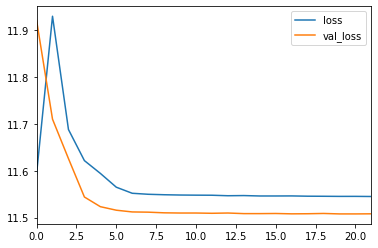

In [40]:
fig, ax = plt.subplots()
pd.read_csv("log.csv", sep=",")[['loss','val_loss']].plot(ax=ax)

fig.savefig("/content/drive/My Drive/GTex_ML/GTex_ML_losses.pdf")

In [0]:
classes = np.unique(df_files["SMTS"])

In [0]:
results = pd.DataFrame(index=classes, columns=classes).fillna(0)
for class_pred, y_test in zip(model.predict_classes(X_test), Y_test):
    results.at[classes[y_test.argmax()], classes[class_pred]]+=1

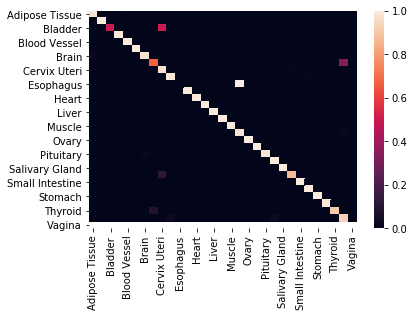

In [41]:
ax = sns.heatmap(results.divide(results.sum(1),0), annot=False)

fig = ax.get_figure()
fig.savefig("/content/drive/My Drive/GTex_ML/GTex_ML_classes.pdf")